In [1]:
import keras
import numpy as np
from keras.models import Sequential
from keras.layers import Dense
from keras import backend as K
from keras.layers import Activation,Dense
from keras.layers.core import Dense,Flatten
from keras.preprocessing.image import *
from keras.layers import *
from IPython.display import display 
from PIL import Image
from keras.optimizers import Adam
from keras.metrics import categorical_crossentropy

from keras.callbacks import CSVLogger
from sklearn.metrics import confusion_matrix
import itertools
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [2]:
train_path='ImgPro/train'
test_path='ImgPro/test'
valid_path='ImgPro/valid'

In [20]:
train_batches=ImageDataGenerator().flow_from_directory(train_path,target_size=(224,224),classes=['dog','cat'],batch_size=10)
valid_batches=ImageDataGenerator().flow_from_directory(valid_path,target_size=(224,224),classes=['dog','cat'],batch_size=1)
test_batches=ImageDataGenerator().flow_from_directory(test_path,target_size=(224,224),classes=['dog','cat'],batch_size=6)

Found 30 images belonging to 2 classes.
Found 4 images belonging to 2 classes.
Found 6 images belonging to 2 classes.


In [11]:
# plots images with labels within jupyter notebook
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

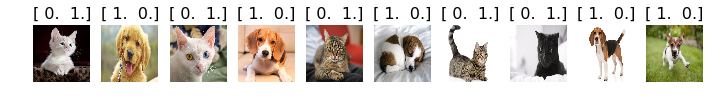

In [12]:
imgs,labels=next(train_batches) #grab a batch
plots(imgs,titles=labels)

In [13]:
model=Sequential([
    Conv2D(32,(3,3),input_shape=(224,224,3),activation='relu'),
    Flatten(),
    Dense(2,activation='softmax')
])

In [14]:
model.compile(Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [15]:
model.fit_generator(train_batches,steps_per_epoch=3,validation_data=valid_batches,validation_steps=4,epochs=5,shuffle=True,verbose=2)

Epoch 1/5
 - 2s - loss: 7.3618 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 2/5
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 3/5
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 4/5
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000
Epoch 5/5
 - 1s - loss: 8.0590 - acc: 0.5000 - val_loss: 8.0590 - val_acc: 0.5000


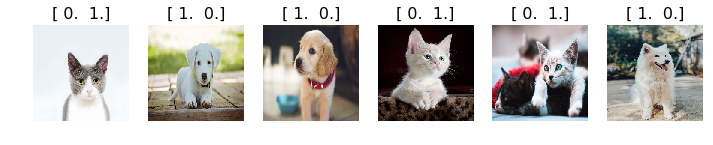

In [21]:
test_imgs,test_labels=next(test_batches)
plots(test_imgs,titles=test_labels)

In [22]:
test_labels=test_labels[:,0]
test_labels

array([ 0.,  1.,  1.,  0.,  0.,  1.], dtype=float32)

In [23]:
prediction=model.predict_generator(test_batches,steps=1,verbose=0)

In [24]:
prediction

array([[ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.],
       [ 1.,  0.]], dtype=float32)

In [26]:
cm=confusion_matrix(test_labels,prediction[:,0])

In [28]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


Confusion matrix, without normalization
[[0 3]
 [0 3]]


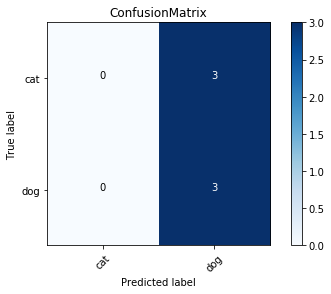

In [29]:
cm_plot_labels=['cat','dog']
plot_confusion_matrix(cm,cm_plot_labels,title='ConfusionMatrix')

<h1>Using VGG16 and FineTune</h1>

In [132]:
vgg16_model=keras.applications.vgg16.VGG16()

In [148]:
#vgg16_model.save('VGG16.h5')

In [133]:
vgg16_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

In [134]:
#CONVERTING THIS MODEL TO SEQUENTIAL
model=Sequential()
for layer in vgg16_model.layers[:-1]: #not copying the last layer
    model.add(layer)

In [135]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

In [136]:
for layer in model.layers:
    layer.trainable=False

In [137]:
model.add(Dense(2,activation='softmax'))
#UPDATE LAST LAYER CONTAINING 1000 CLASSES INTO 2

In [138]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
_________________________________________________________________
block3_conv1 (Conv2D)        (None, 56, 56, 256)       295168    
__________

<h1>Train</h1>

In [139]:
model.compile(Adam(lr=0.0001),loss='categorical_crossentropy',metrics=['accuracy'])

In [141]:
model.fit_generator(train_batches,steps_per_epoch=3,validation_data=valid_batches,validation_steps=4,epochs=15,shuffle=True,verbose=2)

Epoch 1/15
 - 11s - loss: 0.4920 - acc: 0.7667 - val_loss: 0.2528 - val_acc: 0.7500
Epoch 2/15
 - 10s - loss: 0.3352 - acc: 0.8667 - val_loss: 0.1952 - val_acc: 1.0000
Epoch 3/15
 - 10s - loss: 0.2238 - acc: 0.9333 - val_loss: 0.1571 - val_acc: 1.0000
Epoch 4/15
 - 10s - loss: 0.1759 - acc: 0.9333 - val_loss: 0.1309 - val_acc: 1.0000
Epoch 5/15
 - 10s - loss: 0.1108 - acc: 1.0000 - val_loss: 0.1135 - val_acc: 1.0000
Epoch 6/15
 - 10s - loss: 0.0879 - acc: 1.0000 - val_loss: 0.1014 - val_acc: 1.0000
Epoch 7/15
 - 10s - loss: 0.0630 - acc: 1.0000 - val_loss: 0.0928 - val_acc: 1.0000
Epoch 8/15


KeyboardInterrupt: 

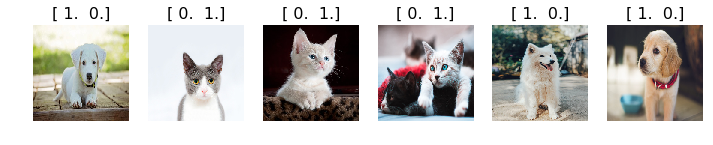

In [142]:
test_imgs,test_labels=next(test_batches)
plots(test_imgs,titles=test_labels)

In [143]:
test_labels=test_labels[:,0]
test_labels

array([ 1.,  0.,  0.,  0.,  1.,  1.], dtype=float32)

In [144]:
prediction=model.predict_generator(test_batches,steps=1,verbose=0)

In [146]:
cm=confusion_matrix(test_labels,np.round(prediction[:,0]))

Confusion matrix, without normalization
[[3 0]
 [0 3]]


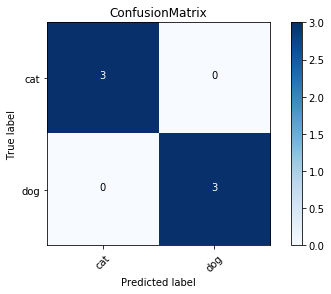

In [147]:
cm_plot_labels=['cat','dog']
plot_confusion_matrix(cm,cm_plot_labels,title='ConfusionMatrix')

<h1>VGG16 model on custom dataset with 2 classes achieves 100% accuracy</h1>